In [1]:
import warnings
from transformers import logging
import os
import json
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoModel, AutoTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
import zipfile
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# suppress all Python warnings
warnings.filterwarnings("ignore")

# suppress Hugging Face `UserWarning`s and model loading messages
logging.set_verbosity_error()

In [2]:
def extract(zip_path, extract_dir):
    """
    Unzip zip_path into extract_dir if extract_dir does not already exist.
    """
    if not os.path.isdir(extract_dir):
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(extract_dir)
        print(f"✅ Extracted to {extract_dir}")

archives = [
    ('/content/heBERT_model.zip',          'heBERT_complete_model'),
    ('/content/alephbert_model.zip',       'alephbert_complete_model'),
    ('/content/alephbertGimel_model.zip',  'alephbertgimmel_complete_model'),
]


for zip_path, extract_dir in archives:
    extract(zip_path, extract_dir)

✅ Extracted to heBERT_complete_model
✅ Extracted to alephbert_complete_model
✅ Extracted to alephbertgimmel_complete_model


In [3]:
# 1. Load and fit label encoder on training intents
train = pd.read_csv('/content/train.csv')
le = LabelEncoder()
le.fit(train['intent'])

# 2. Load test datasets, drop duplicates, and encode labels
elderly_df = pd.read_csv('/content/elderly.csv').drop_duplicates().reset_index(drop=True)
young_df   = pd.read_csv('/content/young.csv').drop_duplicates().reset_index(drop=True)

for df in (elderly_df, young_df):
    df['intent_num'] = le.transform(df['intent'])

In [4]:
# Check and remove duplicates in train
train_duplicates = train.duplicated().sum()
if train_duplicates > 0:
    print(f"Found {train_duplicates} duplicate rows in train.csv.")
    train = train.drop_duplicates()
else:
    print("No duplicate rows found in train.csv.")
print(f"Train set size after deduplication: {len(train)} rows")

# Check and remove duplicates in elderly test set
test_duplicates = elderly_df.duplicated().sum()
if test_duplicates > 0:
    print(f"Found {test_duplicates} duplicate rows in elderly-test.csv.")
    elderly_df = elderly_df.drop_duplicates()
else:
    print("No duplicate rows found in elderly-test.csv.")
print(f"Elderly test set size after deduplication: {len(elderly_df)} rows")

# Check and remove duplicates in young test set
test_duplicates = young_df.duplicated().sum()
if test_duplicates > 0:
    print(f"Found {test_duplicates} duplicate rows in young-test.csv.")
    young_df = young_df.drop_duplicates()
else:
    print("No duplicate rows found in young-test.csv.")
print(f"Young test set size after deduplication: {len(young_df)} rows")


Found 3884 duplicate rows in train.csv.
Train set size after deduplication: 2514 rows
No duplicate rows found in elderly-test.csv.
Elderly test set size after deduplication: 295 rows
No duplicate rows found in young-test.csv.
Young test set size after deduplication: 415 rows


In [5]:
# 3. Define the classification model wrapping a pretrained BERT
class BertForIntentClassification(nn.Module):
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(bert_model.config.hidden_size, num_classes)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0]  # take [CLS] token embedding
        return self.classifier(self.dropout(cls_token))


def load_saved_model(model_dir):
    """Load tokenizer, model and intent mapping from a saved folder."""
    import json, torch
    from transformers import AutoModel, AutoTokenizer

    # load config & intent map
    with open(f"{model_dir}/model_config.json")   as f:
        cfg = json.load(f)
    with open(f"{model_dir}/intent_mapping.json") as f:
        intent_map = json.load(f)

    # load tokenizer and base transformer
    tokenizer = AutoTokenizer.from_pretrained(f"{model_dir}/tokenizer")
    base_model = AutoModel.from_pretrained(cfg["base_model_name"])

    # build classifier and load weights
    model = BertForIntentClassification(base_model, cfg["num_classes"])
    state = torch.load(f"{model_dir}/model_weights.pt", map_location='cpu')
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    return model, tokenizer, intent_map



In [14]:
# Encode labels
le = LabelEncoder()
train['intent_num'] = le.fit_transform(train['intent'])
map_intent = dict(zip(le.transform(le.classes_), le.classes_))



In [6]:
# 5. Evaluation helper function
def evaluate(df, label, batch_size=64):
    texts  = df['transcript_hebrew'].tolist()
    labels = df['intent_num'].tolist()

    # Tokenize on CPU
    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    # build dataset (still on CPU)
    dataset = TensorDataset(
        enc['input_ids'],
        enc['attention_mask'],
        torch.tensor(labels, dtype=torch.long)
    )
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    preds, trues = [], []
    with torch.no_grad():
        for input_ids, attention_mask, y in loader:
            # move inputs to same device as model
            input_ids      = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            logits = model(input_ids, attention_mask)
            batch_preds = torch.argmax(logits, dim=1)

            # send preds back to CPU before converting
            preds.extend(batch_preds.cpu().tolist())
            trues.extend(y.tolist())

    # compute metrics on CPU lists
    acc = accuracy_score(trues, preds)
    f1  = f1_score(trues, preds, average='macro')
    print(f"\nFinal Evaluation on {label}:")
    print(f"  Accuracy: {acc*100:.2f}%")
    print(f"  Macro F1:  {f1:.4f}\n")
    print(classification_report(
        trues, preds,
        target_names=[intent_map[str(i)] for i in sorted(set(trues + preds))]
    ))

    # return metrics + raw predictions + true labels
    return acc, f1, preds, trues


In [7]:
def evaluate_vs_siri(df_with_label, preds, group_name, map_intent):
    assert len(preds) == len(df_with_label), "Mismatch between predictions and dataframe length"

    df_with_label = df_with_label.copy()
    df_with_label["model_pred"] = preds
    df_with_label["is_correct"] = df_with_label["intent_num"] == df_with_label["model_pred"]

    # Grouping based on Siri performance
    total = len(df_with_label)
    siri_failures = df_with_label[df_with_label["label_intent"] == 0]
    siri_successes = df_with_label[df_with_label["label_intent"] == 1]

    # Model successes
    correct_on_failures = siri_failures["is_correct"].sum()
    correct_on_successes = siri_successes["is_correct"].sum()

    # Accuracy rates
    rate_correct_on_failures = correct_on_failures / len(siri_failures) if len(siri_failures) > 0 else None
    rate_correct_on_successes = correct_on_successes / len(siri_successes) if len(siri_successes) > 0 else None
    overall_accuracy = accuracy_score(df_with_label["intent_num"], df_with_label["model_pred"])
    macro_f1 = f1_score(df_with_label["intent_num"], df_with_label["model_pred"], average="macro")

    # Summary table
    summary = {
        "Group": group_name,
        "Total Samples": total,
        "Siri Failures": len(siri_failures),
        "Siri Successes": len(siri_successes),
        "Model Accuracy on Siri Failures": f"{rate_correct_on_failures:.2%}" if rate_correct_on_failures is not None else "N/A",
        "Model Accuracy on Siri Successes": f"{rate_correct_on_successes:.2%}" if rate_correct_on_successes is not None else "N/A",
        "Overall Accuracy": f"{overall_accuracy:.2%}",
        "Macro F1": f"{macro_f1:.4f}"
    }

    return pd.DataFrame([summary])


In [8]:
# pre-define containers for each model & group
preds_hebert_elderly = None
preds_hebert_young = None
preds_alephbert_elderly = None
preds_alephbert_young = None
preds_alephbertgimel_elderly = None
preds_alephbertgimel_young = None

def summarize_all_vs_siri(model_specs, dfs_with_label):
    """
    model_specs: list of (model_dir, model_label, batch_size)
    dfs_with_label: dict of {group_name: DataFrame_with_label_and_intent_num}
    returns: DataFrame with one summary row per (group, model)
    Also populates globals() with preds_<model>_<group> arrays.
    """
    all_summaries = []
    for model_dir, model_label, bs in model_specs:
        # load model/tokenizer/intent_map
        model, tokenizer, intent_map = load_saved_model(model_dir)
        globals().update({'model': model, 'tokenizer': tokenizer, 'intent_map': intent_map})

        for group_name, df in dfs_with_label.items():
            # run evaluate() to get preds
            acc, f1, preds, trues = evaluate(df, f"{group_name} ({model_label})", batch_size=bs)

            # store preds in global variables named preds_<model>_<group>
            var_name = f"preds_{model_label.lower().replace('-', '')}_{group_name.lower()}"
            globals()[var_name] = preds

            # compare vs Siri
            summary = evaluate_vs_siri(df, preds, group_name, intent_map)
            summary['Model'] = model_label
            summary['Batch Size'] = bs
            all_summaries.append(summary)

    return pd.concat(all_summaries, ignore_index=True)

# specify your saved-model folders, labels & batch sizes
model_specs = [
    ("heBERT_complete_model",          "HeBERT",           64),
    ("alephbert_complete_model",       "AlephBERT",        64),
    ("alephbertgimmel_complete_model", "AlephBERT-Gimel",  32),
]

# these DataFrames must include 'label_intent' and 'intent_num'
dfs_with_label = {
    "Elderly": elderly_df,
    "Young":   young_df,
}

# run summary
summary_df = summarize_all_vs_siri(model_specs, dfs_with_label)

print("\n📊 Evaluation Summary vs Siri across all models:")
print(summary_df)



config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]


Final Evaluation on Elderly (HeBERT):
  Accuracy: 94.58%
  Macro F1:  0.9437

                   precision    recall  f1-score   support

        alarm_set       1.00      0.97      0.98        33
     calendar_set       1.00      0.97      0.98        33
     call_contact       0.88      0.81      0.85        27
     camera_query       1.00      0.93      0.96        28
      iot_wemo_on       1.00      0.91      0.95        11
lists_createoradd       0.94      1.00      0.97        32
            query       1.00      0.92      0.96        25
     send_message       0.95      0.83      0.88        23
  transport_query       0.89      1.00      0.94        73
    weather_query       0.91      1.00      0.95        10

         accuracy                           0.95       295
        macro avg       0.96      0.93      0.94       295
     weighted avg       0.95      0.95      0.95       295


Final Evaluation on Young (HeBERT):
  Accuracy: 98.55%
  Macro F1:  0.9745

               

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]


Final Evaluation on Elderly (AlephBERT):
  Accuracy: 95.25%
  Macro F1:  0.9526

                   precision    recall  f1-score   support

        alarm_set       1.00      0.88      0.94        33
     calendar_set       0.89      1.00      0.94        33
     call_contact       0.83      0.93      0.88        27
     camera_query       1.00      0.96      0.98        28
      iot_wemo_on       1.00      1.00      1.00        11
lists_createoradd       1.00      1.00      1.00        32
            query       1.00      0.92      0.96        25
     send_message       0.95      0.78      0.86        23
  transport_query       0.95      1.00      0.97        73
    weather_query       1.00      1.00      1.00        10

         accuracy                           0.95       295
        macro avg       0.96      0.95      0.95       295
     weighted avg       0.96      0.95      0.95       295


Final Evaluation on Young (AlephBERT):
  Accuracy: 99.04%
  Macro F1:  0.9821

         

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/740M [00:00<?, ?B/s]


Final Evaluation on Elderly (AlephBERT-Gimel):
  Accuracy: 94.92%
  Macro F1:  0.9426

                   precision    recall  f1-score   support

        alarm_set       1.00      0.97      0.98        33
     calendar_set       1.00      1.00      1.00        33
     call_contact       0.77      0.85      0.81        27
     camera_query       0.97      1.00      0.98        28
      iot_wemo_on       1.00      1.00      1.00        11
lists_createoradd       0.94      1.00      0.97        32
            query       1.00      0.88      0.94        25
     send_message       1.00      0.70      0.82        23
  transport_query       0.95      1.00      0.97        73
    weather_query       0.91      1.00      0.95        10

         accuracy                           0.95       295
        macro avg       0.95      0.94      0.94       295
     weighted avg       0.95      0.95      0.95       295


Final Evaluation on Young (AlephBERT-Gimel):
  Accuracy: 99.04%
  Macro F1:  0.982

השוואת תוצאות לסירי:

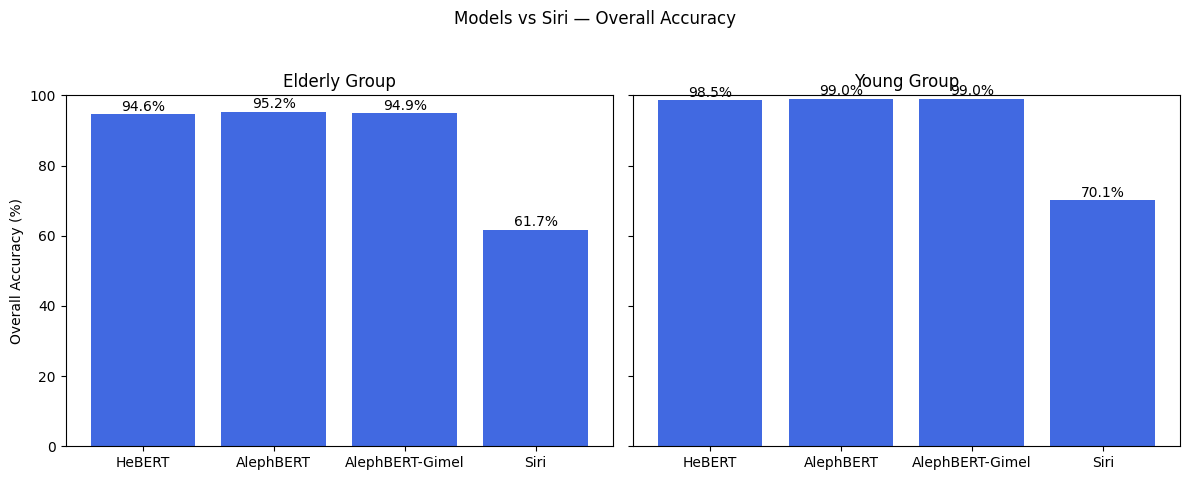

In [9]:

# 1. Prepare plotting DataFrame
plot_df = summary_df[['Group','Model','Overall Accuracy']].copy()
# strip “%” and convert to float
plot_df['Overall Accuracy'] = plot_df['Overall Accuracy'] \
                                .str.rstrip('%') \
                                .astype(float)

# 2. Append Siri baseline values
siri_baseline = [
    {'Group':'Elderly', 'Model':'Siri', 'Overall Accuracy': elderly_df['label_intent'].mean()*100},
    {'Group':'Young',   'Model':'Siri', 'Overall Accuracy': young_df['label_intent'].mean()*100},
]
plot_df = pd.concat([plot_df, pd.DataFrame(siri_baseline)], ignore_index=True)

# 3. Define model & group order
models = ['HeBERT','AlephBERT','AlephBERT-Gimel','Siri']
groups = ['Elderly','Young']
x = np.arange(len(models))

# 4. Plot
fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)

for i, grp in enumerate(groups):
    grp_df = (plot_df[plot_df['Group']==grp]
                .set_index('Model')
                .loc[models]
                .reset_index())

    axs[i].bar(x, grp_df['Overall Accuracy'], color='royalblue')
    axs[i].set_title(f"{grp} Group")
    axs[i].set_xticks(x)
    # make labels horizontal
    axs[i].set_xticklabels(models, rotation=0, ha='center')
    axs[i].set_ylim(0, 100)
    if i == 0:
        axs[i].set_ylabel("Overall Accuracy (%)")

    # annotate each bar
    for j, val in enumerate(grp_df['Overall Accuracy']):
        axs[i].text(x[j], val + 1, f"{val:.1f}%", ha='center')

fig.suptitle("Models vs Siri — Overall Accuracy")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()



שמירת דאטה סט - למודל ניסוח מחדש:

הסיווג כונות של המודל ומה שנכשל בניסוי לטובת ניסוח מחדש


In [20]:
model_name = 'AlephBERT'

# --- Young group ---
df_young = young_df.copy()
df_young['model_pred'] = preds_alephbert_young

# keep only rows where Siri originally failed (label == 0)
df_young = df_young[df_young['label'] == 0]

# build a DataFrame with predicted intent, original Hebrew transcript, and group label
ds_young = df_young[['model_pred', 'transcript_hebrew']].rename(
    columns={
        'model_pred': 'predicted_intent',
        'transcript_hebrew': 'command'
    }
)
ds_young['predicted_intent'] = ds_young['predicted_intent'].map(map_intent)
ds_young['true_intent']      = df_young['intent_num'].map(map_intent)
ds_young['group']            = 'Young'

# --- Elderly group ---
df_elderly = elderly_df.copy()
df_elderly['model_pred'] = preds_alephbert_elderly

# keep only rows where Siri originally failed (label == 0)
df_elderly = df_elderly[df_elderly['label'] == 0]

ds_elderly = df_elderly[['model_pred', 'transcript_hebrew']].rename(
    columns={
        'model_pred': 'predicted_intent',
        'transcript_hebrew': 'command'
    }
)
ds_elderly['predicted_intent'] = ds_elderly['predicted_intent'].map(map_intent)
ds_elderly['true_intent']      = df_elderly['intent_num'].map(map_intent)
ds_elderly['group']            = 'Elderly'

# --- Combine both groups into one final dataset ---
final_ds = pd.concat([ds_young, ds_elderly], ignore_index=True)

# save the filtered model output to CSV with BOM for proper Hebrew encoding
final_ds.to_csv(
    f'{model_name}_predictions.csv',
    index=False,
    encoding='utf-8-sig'
)
print(f"Saved filtered dataset with {len(final_ds)} samples → {model_name}_predictions.csv")


Saved filtered dataset with 382 samples → AlephBERT_predictions.csv
